In [1]:
##Loading some important libraries

import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import tensorflow as tf
from pykalman import KalmanFilter
from statistics import stdev
from filterpy.kalman import KalmanFilter
from filterpy.kalman import predict, update

2024-04-11 11:58:50.375135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##Loading both training and validation sets
train_df = pd.read_csv('~/Desktop/UTK_PhD_material/Semester 2 Spring-24/525 Deep Learning/Project/optiver-trading-at-the-close/train.csv')
test_df = pd.read_csv('~/Desktop/UTK_PhD_material/Semester 2 Spring-24/525 Deep Learning/Project/optiver-trading-at-the-close/example_test_files/test.csv')

In [3]:
## checking the shape of data and representation
print(train_df.shape)
train_df.head()

(5237980, 17)


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
# Checking the number of missing values in each training set column
missing_values_train = train_df.isna().sum(axis=0)
print(missing_values_train)

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64


In [5]:
# Checking the number of missing values in each testing set column
missing_values_test = test_df.isna().sum(axis=0)
print(missing_values_test)

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  18229
near_price                 18000
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
time_id                        0
row_id                         0
currently_scored               0
dtype: int64


In [6]:
## far_price and near_price have most missing values, which are filled using the 0
train_df['far_price'].fillna(0, inplace = True)
train_df['near_price'].fillna(0, inplace = True)

test_df['far_price'].fillna(0, inplace = True)
test_df['near_price'].fillna(0, inplace = True)

In [7]:
# Dropping specified values, which have missing values
train_df.dropna(inplace = True)
train_df.reset_index(inplace = True)

In [8]:
# Making sure the number of missing values in training set
missing_values_train = train_df.isna().sum(axis=0)
print(missing_values_train)

index                      0
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64


In [9]:
# Making sure the number of missing values in testing set
missing_values_test = test_df.isna().sum(axis=0)
print(missing_values_test) 


stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
time_id                    0
row_id                     0
currently_scored           0
dtype: int64


In [10]:
print(train_df.shape)
print(test_df.shape)

(5237760, 18)
(33000, 17)


count    5.237760e+06
mean    -4.758886e-02
std      9.452816e+00
min     -3.852898e+02
25%     -4.559755e+00
50%     -6.020069e-02
75%      4.409552e+00
max      4.460704e+02
Name: target, dtype: float64


/Users/z7a/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


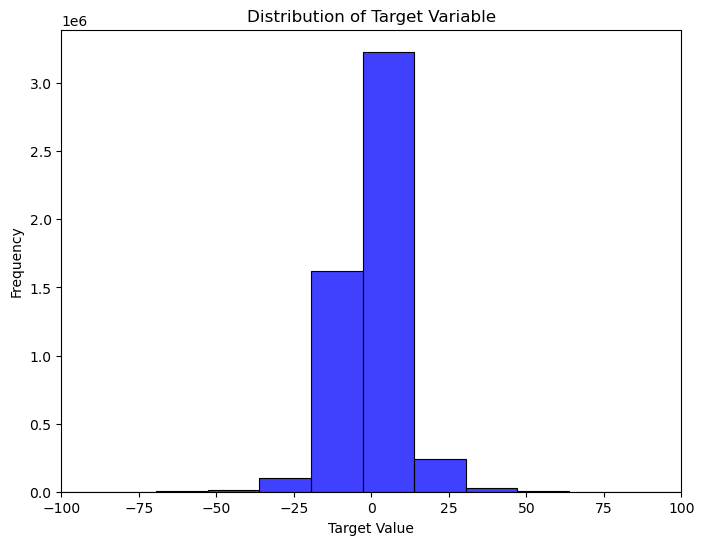

In [11]:
## Understanding the stats of target
print(train_df['target'].describe())

plt.figure(figsize=(8, 6))
sns.histplot(train_df['target'], bins=50,  color='blue')
plt.title('Distribution of Target Variable')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.xlim(-100, 100)
plt.show()

##The target variable appears to be normally distributed.

In [12]:
## We can also see how many unique dates we have in the data set and also how many unique stocks are included in the data set.
print(train_df['stock_id'].unique())

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  70  71  72
  73  74  75  76  77  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 151 152 154 155 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198  78  69 156 150 153 199  79
 135 102]


In [13]:
len(train_df['date_id'].unique())

481

In [14]:
print(len(train_df['stock_id'].unique()))

200


In [15]:
'''
There are 200 unique stocks in the training data set, and 481 different date IDs.
Note that some rows may contain the same date_id and time_id, however different stock ID's.
This represents the "concurrent" price of each stock at each give period of time.
We can visualize this by looking at the first few rows of data.
'''
train_df.head(20)

,index,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,1,0,0,166603.91,-1,0.999896,1642214.25,0.0,0.0,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,2,0,0,302879.87,-1,0.999561,1819368.03,0.0,0.0,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.0,0.0,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,4,0,0,447549.96,-1,0.999532,17860614.95,0.0,0.0,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,5,0,0,0.00,0,1.000635,13552875.92,0.0,0.0,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,6,0,0,969969.40,1,1.000115,3647503.98,0.0,0.0,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,7,0,0,9412959.10,1,0.999818,21261245.87,0.0,0.0,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,8,0,0,2394875.85,1,0.999916,9473209.08,0.0,0.0,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,9,0,0,3039700.65,-1,1.000969,6248958.45,0.0,0.0,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


/var/folders/hz/w0c2pyts6_3_5r9pnldpf7p43zh1h_/T/ipykernel_21474/2084734865.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr_matrix = corr_matrix.applymap(lambda x: np.nan if abs(x) < 1e-10 else x)


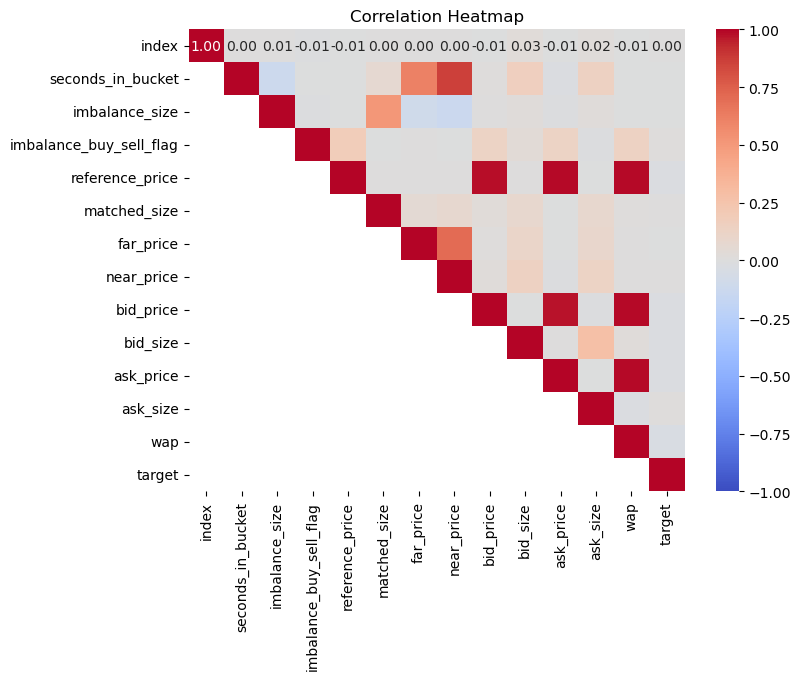

'\nThe correlation analysis which showed that price features are highly correlated.\nWe would like to reduce the "noise" in the model by removing correlated features.\n\nThe reference price, ask price, bid price and wap (weight average price) are highly correlated at 95%+ for all.\n'

In [16]:
##finding correlation btw predictors

columns_to_remove = ['stock_id', 'date_id', 'time_id', 'row_id']
# Remove the specified columns
corr_df = train_df.drop(columns=columns_to_remove)

# Calculate the correlation matrix
corr_matrix = corr_df.corr()
# Create a lower triangular mask
mask = ~np.tri(*corr_matrix.values.shape, k=-1, dtype=bool)

# Apply the mask to set the upper triangle values to NaN
corr_matrix = pd.DataFrame(corr_matrix.values * mask, columns=corr_matrix.columns, index=corr_matrix.index)
# Replace very small values with NaN
corr_matrix = corr_matrix.applymap(lambda x: np.nan if abs(x) < 1e-10 else x)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

'''
The correlation analysis which showed that price features are highly correlated.
We would like to reduce the "noise" in the model by removing correlated features.

The reference price, ask price, bid price and wap (weight average price) are highly correlated at 95%+ for all.
'''

Removing outliers

In [20]:
#It is best practice to remove outliers. Lets see if removing outliers will improve the model performance.
# Specify the column you want to filter
column_name = 'target'

# Adjust these percentiles according to your preference
lower_percentile = 5
upper_percentile = 95

# Calculate lower and upper bounds
lower_bound = np.percentile(train_df[column_name], lower_percentile)
upper_bound = np.percentile(train_df[column_name], upper_percentile)

# Filter the DataFrame based on the bounds
train_df = train_df[(train_df[column_name] > lower_bound) & (train_df[column_name] < upper_bound)]


Kalman filtering

In [21]:
##Calls upon previous function to kalman filter each row in the data set. Will filter the ask, bid, and wap prices and
##then make a new data set with all other entries.
rslt_df = train_df.sort_values(by=['stock_id', 'date_id', "seconds_in_bucket"]).reset_index(drop = True)

In [22]:
from tqdm import tqdm
def kalman_smoother(stock_id: int, date_id: int, data: pd.DataFrame = rslt_df, QRP_noise:list[float] = [0.1, 5, 0.1]):
  subset = data.loc[(data['stock_id'] == stock_id) & (data['date_id'] == date_id), ['seconds_in_bucket','bid_price',"ask_price","wap"]]
  train_data = subset.set_index("seconds_in_bucket")
  train_data1= subset.replace(0, np.nan)

  # Bayesian Kalman filter parameters
  Q_noise, R_noise, P_noise = QRP_noise
  Q = np.eye(3) * Q_noise  # Process noise covariance matrix
  R = np.eye(3) * R_noise   # Measurement noise covariance matrix
  H = np.eye(3)         # Measurement function matrix
  I = np.eye(3)         # Identity matrix

  # Initialize state estimate and covariance matrix
  x_hat = train_data.loc[0, ['bid_price', 'ask_price', 'wap']].values.reshape((3, 1))
  P = np.eye(3) * P_noise  # Initial covariance matrix

  # Kalman filtering
  filtered_data = []
  for _, row in train_data.iterrows():
      z = row.values.reshape(-1, 1)  # Measurement vector

      # Prediction step
      x_hat_minus = x_hat
      P_minus = P + Q

      # Update step
      K = P_minus @ H.T @ np.linalg.inv(H @ P_minus @ H.T + R)  # Kalman gain
      x_hat = x_hat_minus + K @ (z - H @ x_hat_minus)
      P = (I - K @ H) @ P_minus

      filtered_data.append(x_hat.flatten())

  # Convert filtered data to DataFrame
  filtered_df = pd.DataFrame(filtered_data, columns=['filtered_bid_price', 'filtered_asking_price', 'filtered_wap'])
  return filtered_df


In [23]:

def run_all_filterings(data: pd.DataFrame = rslt_df, QRP_noise:list[float] = [0.1, 1, 0.1]):
  unq_stock = data['stock_id'].unique()
  unq_date = data['date_id'].unique()
  frames = []
  for us in tqdm(unq_stock):
    for ud in unq_date:
      try:
        filtered_df = kalman_smoother(us, ud, data = data, QRP_noise=QRP_noise)
        filtered_df['stock_id'] = us
        filtered_df['date_id'] = ud
        frames.append(filtered_df)
      except KeyError as e:
        continue
  filtered_concat = pd.concat(frames, axis = 0, ignore_index=True)
  filtered_concat['seconds_in_bucket'] = data['seconds_in_bucket']
  final_filtered = pd.merge(filtered_concat, data, on = ['stock_id', 'date_id', 'seconds_in_bucket'], how = 'left')
  final_filtered = final_filtered.drop(['bid_price', 'ask_price', 'wap'], axis = 1)
  return final_filtered

In [24]:
filtered_frames = run_all_filterings()
filtered_frames

100%|██████████| 200/200 [1:12:35<00:00, 21.78s/it]


,filtered_bid_price,filtered_asking_price,filtered_wap,stock_id,date_id,seconds_in_bucket,index,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_size,ask_size,target,time_id,row_id
0,0.999812,1.000026,1.000000,0,0,0,0.0,3180602.69,1.0,0.999812,13380276.64,0.000000,0.000000,60651.50,8493.03,-3.029704,0.0,0_0_0
1,0.999812,1.000026,0.999977,0,0,10,191.0,1299772.70,1.0,1.000026,15261106.63,0.000000,0.000000,13996.50,23519.16,0.389814,1.0,0_10_0
2,0.999812,1.000001,0.999945,0,0,20,382.0,1299772.70,1.0,0.999919,15261106.63,0.000000,0.000000,4665.50,12131.60,4.220009,2.0,0_20_0
3,0.999866,1.000034,0.999980,0,0,30,573.0,1299772.70,1.0,1.000133,15261106.63,0.000000,0.000000,55998.00,46203.30,5.450249,3.0,0_30_0
4,0.999964,1.000144,1.000068,0,0,40,764.0,1218204.43,1.0,1.000455,15342674.90,0.000000,0.000000,14655.95,26610.45,3.169775,4.0,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216990,1.002050,1.002368,1.002185,199,480,510,5237379.0,2658917.61,-1.0,1.002764,23972081.09,1.000859,1.001494,677012.04,347268.87,-9.750128,26451.0,480_510_199
3216991,1.002243,1.002561,1.002399,199,480,520,5237579.0,1352558.88,-1.0,1.001812,23978379.68,1.000859,1.001494,225361.65,194630.52,3.629923,26452.0,480_520_199
3216992,1.002127,1.002444,1.002286,199,480,530,5237779.0,1352558.88,-1.0,1.001812,23978379.68,1.000859,1.001494,285559.05,214513.32,4.760027,26453.0,480_530_199
3216993,1.002042,1.002359,1.002207,199,480,540,5237979.0,1884285.71,-1.0,1.002129,24073677.32,1.000859,1.001494,250081.44,300167.56,-6.530285,26454.0,480_540_199


In [25]:
filtered_frames.isna().sum(axis=0)

filtered_bid_price              0
filtered_asking_price           0
filtered_wap                    0
stock_id                        0
date_id                         0
seconds_in_bucket               0
index                      406997
imbalance_size             406997
imbalance_buy_sell_flag    406997
reference_price            406997
matched_size               406997
far_price                  406997
near_price                 406997
bid_size                   406997
ask_size                   406997
target                     406997
time_id                    406997
row_id                     406997
dtype: int64

In [26]:
filtered_frames.dropna(inplace = True)
filtered_frames.isna().sum(axis=0)

filtered_bid_price         0
filtered_asking_price      0
filtered_wap               0
stock_id                   0
date_id                    0
seconds_in_bucket          0
index                      0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_size                   0
ask_size                   0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [58]:
train_df=filtered_frames
X = train_df.drop('target', axis=1)  # Features
y = train_df['target']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [33]:
# Initialize the LightGBM regressor
feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price',
               'matched_size', 'filtered_bid_price','filtered_asking_price','filtered_wap', 'ask_size']


lgbm_model = LGBMRegressor( objective = 'mae', randome_state = 55)
# Train the model
lgbm_model.fit(X_train[feature_list], y_train)

[LightGBM] [Warning] Unknown parameter: randome_state
[LightGBM] [Warning] Unknown parameter: randome_state
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 2247998, number of used features: 9
[LightGBM] [Info] Start training from score -0.050068


LGBMRegressor(objective='mae', randome_state=55)

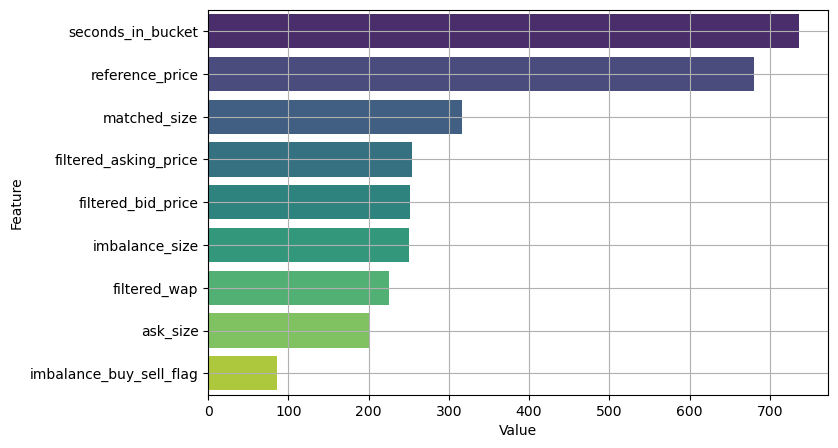

In [34]:
# Get feature importances
importances = lgbm_model.feature_importances_
feat_importances = pd.DataFrame({'Value':importances,'Feature':feature_list}).sort_values(by="Value",ascending=False)
# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=feat_importances, x='Value', y='Feature', palette='viridis')
plt.grid(":")
plt.show()

In [35]:
# Predict on the training set
y_train_pred = lgbm_model.predict(X_train[feature_list])

# Predict on the test set
y_test_pred = lgbm_model.predict(X_test[feature_list])

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate R-squared (R2) score for training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')


# Calculate R-squared (R2) score for training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Set:')
print(f'r2_train: {r2_train}')

print('\n')

print(f'Test Set:')
print(f'r2_test: {r2_test}')

#It is noted that, the MAE score is significantly decreased from 6 to 4.25 on testing after removing outliers and applying kalman filtering.


[LightGBM] [Warning] Unknown parameter: randome_state
[LightGBM] [Warning] Unknown parameter: randome_state
Training Set:
Mean Absolute Error (MAE): 3.6532024892912562


Test Set:
Mean Absolute Error (MAE): 3.5729190045458203
Training Set:
r2_train: 0.03773082660271754


Test Set:
r2_test: 0.03542512143494447


In [ ]:
'''
Removing the outlier values significatnly improved test MAE to 3.57.
Data preprocessing is an important step in machine learning.
As shown in the example above, "clean and structred" data can make a significant difference in results.
'''

## Baseline (Plain) LSTM


In [119]:
X_train[feature_list]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train[feature_list])
X_test_scaled = scaler.transform(X_test[feature_list])

In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])
# fit model
history1=model.fit(X_train_scaled, y_train, epochs=50, verbose=1, batch_size=32, validation_split=0.2)

yhat_train = model.predict(X_train_scaled)
yhat_test = model.predict(X_test_scaled)

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, yhat_train)
mae_test = mean_absolute_error(y_test, yhat_test)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Epoch 1/50
56200/56200 [==============================] - 380s 7ms/step - loss: 3.7487 - accuracy: 8.1906e-04 - val_loss: 3.7075 - val_accuracy: 9.0970e-04
Epoch 2/50
56200/56200 [==============================] - 390s 7ms/step - loss: 3.7456 - accuracy: 8.3130e-04 - val_loss: 3.7071 - val_accuracy: 9.0970e-04
Epoch 3/50
56200/56200 [==============================] - 404s 7ms/step - loss: 3.7455 - accuracy: 8.3130e-04 - val_loss: 3.7071 - val_accuracy: 9.0970e-04
Epoch 4/50
56200/56200 [==============================] - 436s 8ms/step - loss: 3.7455 - accuracy: 8.3130e-04 - val_loss: 3.7072 - val_accuracy: 9.0970e-04
Epoch 5/50
56200/56200 [==============================] - 406s 7ms/step - loss: 3.7454 - accuracy: 8.3130e-04 - val_loss: 3.7072 - val_accuracy: 9.0970e-04
Epoch 6/50
56200/56200 [==============================] - 420s 7ms/step - loss: 3.7455 - accuracy: 8.3130e-04 - val_loss: 3.7072 - val_accuracy: 9.0970e-04
Epoch 7/50
56200/56200 [==============================] - 370s 7

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


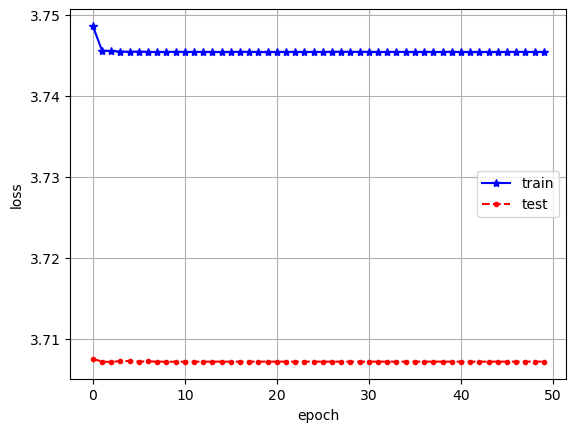

In [166]:
# summarize history for loss
plt.plot(history1.history['loss'], '-b', marker='*')
plt.plot(history1.history['val_loss'], '--r', marker='.')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid(":")
plt.savefig('Fig5 - baselinelstm_kalman.eps')
plt.savefig('Fig5 - baselinelstm_kalman.jpg')
plt.show()

## Bidirectional LSTM

In [140]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding
# Reshape input data

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define your model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu',return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=50, verbose=1, batch_size=32, validation_split=0.2)


yhat_train = model.predict(X_train_reshaped)
yhat_test = model.predict(X_test_reshaped)

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, yhat_train)
mae_test = mean_absolute_error(y_test, yhat_test)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Epoch 1/50
56200/56200 [==============================] - 175s 3ms/step - loss: 3.6932 - accuracy: 6.4835e-04 - val_loss: 3.6548 - val_accuracy: 6.5391e-04
Epoch 2/50
56200/56200 [==============================] - 229s 4ms/step - loss: 3.6793 - accuracy: 6.1499e-04 - val_loss: 3.6441 - val_accuracy: 6.6726e-04
Epoch 3/50
56200/56200 [==============================] - 222s 4ms/step - loss: 3.6714 - accuracy: 6.0165e-04 - val_loss: 3.6368 - val_accuracy: 6.8728e-04
Epoch 4/50
56200/56200 [==============================] - 248s 4ms/step - loss: 3.6665 - accuracy: 5.9942e-04 - val_loss: 3.6354 - val_accuracy: 6.7616e-04
Epoch 5/50
56200/56200 [==============================] - 232s 4ms/step - loss: 3.6632 - accuracy: 5.8274e-04 - val_loss: 3.6353 - val_accuracy: 6.5836e-04
Epoch 6/50
56200/56200 [==============================] - 224s 4ms/step - loss: 3.6607 - accuracy: 5.8608e-04 - val_loss: 3.6352 - val_accuracy: 6.6059e-04
Epoch 7/50
56200/56200 [==============================] - 166s 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


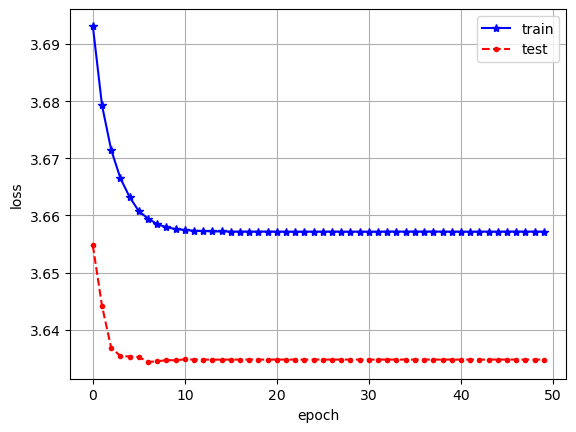

In [151]:
# summarize history for loss
plt.plot(history.history['loss'], '-b', marker='*')
plt.plot(history.history['val_loss'], '--r', marker='.')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid(":")
plt.savefig('Fig1 - lstm_kalman.eps')
plt.savefig('Fig1 - lstm_kalman.jpg')
plt.show()


Plain DNN model

In [156]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)), # Input layer with 100 neurons
    tf.keras.layers.Dense(50, activation='relu'), # Hidden layer with 50 neurons
    tf.keras.layers.Dense(1) # Output layer with 1 neuron
])

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Print model summary
model.summary()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mae')
# fit model
history4=model.fit(X_train_scaled, y_train, epochs=50, verbose=1, batch_size=16, validation_split=0.2)

yhat_train = model.predict(X_train_scaled)
yhat_test = model.predict(X_test_scaled)

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, yhat_train)
mae_test = mean_absolute_error(y_test, yhat_test)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')


Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 100)               1000      
                                                                 
 dense_62 (Dense)            (None, 50)                5050      
                                                                 
 dense_63 (Dense)            (None, 1)                 51        
                                                                 
Total params: 6101 (23.83 KB)
Trainable params: 6101 (23.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
112400/112400 [==============================] - 115s 1ms/step - loss: 3.6965 - val_loss: 3.6523
Epoch 2/50
112400/112400 [==============================] - 116s 1ms/step - loss: 3.6791 - val_loss: 3.6403
Epoch 3/50
112400/112400 [==============================] - 118s 1m

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


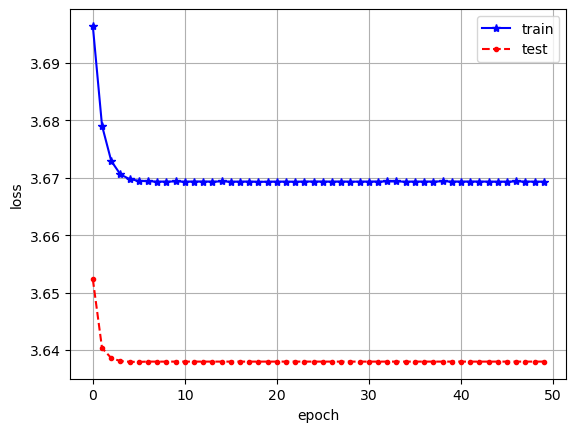

In [159]:
# summarize history for loss
plt.plot(history4.history['loss'], '-b', marker='*')
plt.plot(history4.history['val_loss'], '--r', marker='.')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid(":")
plt.savefig('Fig2 - dnn_kalman.eps')
plt.savefig('Fig2 - dnn_kalman.jpg')
plt.show()

## CNN LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0],  X_train_scaled.shape[1],1))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0],  X_test_scaled.shape[1],1))

model = Sequential()

# CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])
# fit model
history2=model.fit(X_train_reshaped, y_train, epochs=20, verbose=1, batch_size=32, validation_split=0.2)

yhat_train = model.predict(X_train_reshaped)
yhat_test = model.predict(X_test_reshaped)

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, yhat_train)
mae_test = mean_absolute_error(y_test, yhat_test)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Epoch 1/20
56200/56200 [==============================] - 367s 7ms/step - loss: 3.7164 - accuracy: 7.0229e-04 - val_loss: 3.6725 - val_accuracy: 7.6957e-04
Epoch 2/20
56200/56200 [==============================] - 420s 7ms/step - loss: 3.7021 - accuracy: 6.5614e-04 - val_loss: 3.6626 - val_accuracy: 7.8959e-04
Epoch 3/20
56200/56200 [==============================] - 521s 9ms/step - loss: 3.6925 - accuracy: 6.3167e-04 - val_loss: 3.6530 - val_accuracy: 6.8950e-04
Epoch 4/20
56200/56200 [==============================] - 469s 8ms/step - loss: 3.6856 - accuracy: 6.1221e-04 - val_loss: 3.6511 - val_accuracy: 6.7838e-04
Epoch 5/20
56200/56200 [==============================] - 379s 7ms/step - loss: 3.6820 - accuracy: 5.9942e-04 - val_loss: 3.6470 - val_accuracy: 6.8505e-04
Epoch 6/20
56200/56200 [==============================] - 344s 6ms/step - loss: 3.6802 - accuracy: 5.9442e-04 - val_loss: 3.6460 - val_accuracy: 6.8950e-04
Epoch 7/20
56200/56200 [==============================] - 360s 6

In [152]:
yhat_train = model.predict(X_train_reshaped)
yhat_test = model.predict(X_test_reshaped)

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, yhat_train)
mae_test = mean_absolute_error(y_test, yhat_test)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

17563/17563 [==============================] - 36s 2ms/step
Training Set:
Mean Absolute Error (MAE): 3.6697364108687274


Test Set:
Mean Absolute Error (MAE): 3.5856043300080267


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


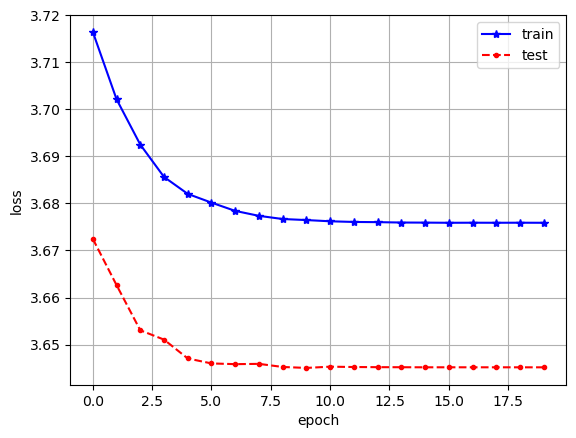

In [160]:
# summarize history for loss
plt.plot(history2.history['loss'], '-b', marker='*')
plt.plot(history2.history['val_loss'], '--r', marker='.')
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid(":")
plt.savefig('Fig3 - CNN_lstm_kalman.eps')
plt.savefig('Fig3 - CNN_lstm_kalman.jpg')
plt.show()



## TCN model

In [111]:
#!pip install keras-tcn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 17.2 MB/s eta 0:00:0000:0100:01


In [154]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_tcn_model(input_shape, output_units, tcn_units, kernel_size, num_layers):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Two TCN layers
    for i in range(num_layers):
        model.add(Conv1D(filters=tcn_units, kernel_size=kernel_size, padding='causal', dilation_rate=2**i, activation='relu'))
    
    # Flatten layer
    model.add(Flatten())
    
    # Output layer
    model.add(Dense(output_units))
    
    return model

# Define hyperparameters
input_shape = (X_train_scaled.shape[1],1)  # Shape of your input time series data
output_units = 1  # Number of output units (for regression)
tcn_units = 64  # Number of units in TCN layers
kernel_size = 3  # Kernel size for TCN layers
num_layers = 2  # Number of TCN layers

# Build the TCN model
model = build_tcn_model(input_shape, output_units, tcn_units, kernel_size, num_layers)

# Print model summary
model.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mae')
# fit model
history3=model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

yhat_train = model.predict(X_train_scaled)
yhat_test = model.predict(X_test_scaled)

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, yhat_train)
mae_test = mean_absolute_error(y_test, yhat_test)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')


Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 9, 64)             256       
                                                                 
 conv1d_34 (Conv1D)          (None, 9, 64)             12352     
                                                                 
 flatten_19 (Flatten)        (None, 576)               0         
                                                                 
 dense_60 (Dense)            (None, 1)                 577       
                                                                 
Total params: 13185 (51.50 KB)
Trainable params: 13185 (51.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
56200/56200 [==============================] - 303s 5ms/step - loss: 3.7108 - accuracy: 6.9173e-04 - val_loss: 3.6681 - val_accuracy: 8.45

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


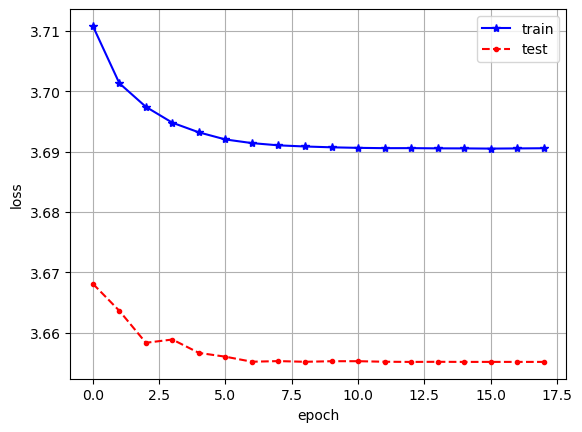

In [161]:
# summarize history for loss
plt.plot(history3.history['loss'], '-b', marker='*')
plt.plot(history3.history['val_loss'], '--r', marker='.')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid(":")
plt.savefig('Fig4 - TCN_kalman.eps')
plt.savefig('Fig4 - TCN_kalman.jpg')
plt.show()